In [1]:
import tensorflow as tf
print(tf.__version__)

2023-11-16 22:59:34.728186: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-16 22:59:37.424104: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2.13.1


In [2]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from keras import callbacks

# from DataSetsLoader import DataSetsLoader
from OrthogonalRegularizer import OrthogonalRegularizer

tf.random.set_seed(123)


In [3]:
NUM_POINTS = 4096
NUM_CLASSES = 3
BATCH_SIZE = 32

In [4]:
import os
import glob
from random import shuffle
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from math import floor

class DataSetsLoader:
    def __init__(self, num_points=4096 , num_class=3): 
        self.num_points = num_points
        self.num_class = num_class
        self.load_datasets()
          

    def load_datasets(self):
        os.chdir("/mnt/ogEk-realtime/")
        new_dir = os.getcwd()   
      
    def transform_to_tensorflow_dataset(self):
        points = []
        labels = []
        test_points = []
        test_labels = []
        
        all_files = os.listdir("/mnt/ogEk-realtime/")
        data_files = list(filter(lambda file: file.endswith('.txt'), all_files))
        shuffle(data_files)

        for f in data_files: 
            os.chdir(r"/mnt/ogEk-realtime/")                       
            try:
                data = pd.read_csv(f, sep=" ")
                data = data.fillna(method='ffill').fillna(method='bfill')
                if (len(data)>=self.num_points):
                     #We sample a point cloud file using `.sample()` which performs a unifrom random sampling. Here we sample at 4096 locations
                    points.append(data.sample(self.num_points))  
                    labels.append(f[0])
            except Exception as e:
                print(e)
        
        test_points = list(points)  
        test_labels = list(labels)
        
        return (            
            np.array(test_points, dtype="object").astype(np.float32),
            np.array(test_labels, dtype="object")
        )       

# if __name__ == "__main__":
#     datasets_loader = DataSetsLoader()
#     # Get the tensorflow compatiable dataset
#     datasets_loader.transform_to_tensorflow_dataset()

In [7]:
points = []
labels = []
test_points = []
test_labels = []
               
all_files = os.listdir("/mnt/ogEk-realtime/")
data_files = list(filter(lambda file: file.endswith('.txt'), all_files))
shuffle(data_files)

for f in data_files: 
    os.chdir(r"/mnt/ogEk-realtime/")                       
    try:
        data = pd.read_csv(f, sep=" ")
        data = data.fillna(method='ffill').fillna(method='bfill')
        if (len(data)>=4096):
             #We sample a point cloud file using `.sample()` which performs a unifrom random sampling. Here we sample at 4096 locations
            points.append(data.sample(4096))  
            labels.append(f[0])
    except Exception as e:
        print(e)
                
print(points)                

[            //X          Y         Z
4152  23.246948   6.657959  0.110001
576    2.666992  13.037964  0.373001
1408   4.610962  15.115967  0.341000
3423  17.546997   7.646973  0.223000
1342   4.447021   2.160950  0.404999
...         ...        ...       ...
1448   4.713013   3.506958  0.340000
3728  19.851929   6.140991  0.134998
716    2.991943  13.543945  0.369999
2734  12.520020   5.268982  0.278000
662    2.865967  19.807983  0.367001

[4096 rows x 3 columns],              //X           Y         Z
211    18.268982   91.351990  0.438999
3426  161.562988   97.138977  1.405998
1583   74.665985   45.182983  0.599998
748    40.911987   10.751984  0.316998
2747  125.953003   96.511993  1.132000
...          ...         ...       ...
2628  120.261993   28.647980  0.790001
1931   89.093994  122.000000  1.284000
686    38.416992   76.048004  0.434998
2152   98.639984   13.535004  0.549000
2975  137.286987   33.500000  0.922001

[4096 rows x 3 columns],             //X         Y         Z

In [8]:
# Load Datasets
datasets_loader = DataSetsLoader(NUM_POINTS,NUM_CLASSES)
test_points,test_labels = datasets_loader.transform_to_tensorflow_dataset()

In [9]:
def label_mapping(lbl):
    if(lbl.lower() == 'b'):
        return 0
    if(lbl.lower() == 'g'):
        return 1
    if(lbl.lower() == 'v'):
        return 2
    else:
        return None

In [10]:
test_label=[]
for j in test_labels:  
    label_tst = label_mapping(j.lower())
    if(label_tst!=None):
        test_label.append(label_tst)
        
print(test_label)   

[1, 2, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 2, 0, 0, 0, 0, 0, 2, 2, 1, 0, 2, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 2, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 2, 1, 1, 0, 0, 1, 0, 2, 1, 2, 1, 2, 0, 0, 0, 0, 1, 1, 0, 2, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 2, 1, 0, 0, 2, 0, 0, 1, 1, 0, 1, 1, 1, 0]


In [11]:

test_dataset = tf.data.Dataset.from_tensor_slices((test_points, test_label))
test_dataset = test_dataset.batch(BATCH_SIZE)

2023-11-16 23:08:48.888229: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [12]:
def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    x = layers.BatchNormalization(momentum=0.99)(x)
    # return layers.Activation("relu")(x)
    return layers.LeakyReLU(alpha=0.3)(x)


def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.99)(x)
    # return layers.Activation("relu")(x)
    return layers.LeakyReLU(alpha=0.3)(x)



In [13]:
def tnet(inputs, num_features):

    # Initalise bias as the indentity matrix
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)

    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,
    )(x)
    feat_T = layers.Reshape((num_features, num_features))(x)
    # Apply affine transformation to input features
    return layers.Dot(axes=(2, 1))([inputs, feat_T])



In [14]:
initial_learning_rate = 0.001    
decay_steps = 7000  #200000
decay_rate = 0.7
# MOMENTUM = 0.99
def get_learning_rate(initial_learning_rate,decay_steps, decay_rate):
    
    learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps, decay_rate, staircase=False, name=None)
    return learning_rate 

In [15]:
def create_model():
    inputs = keras.Input(shape=(NUM_POINTS, 3))

    x = tnet(inputs, 3)
    x = conv_bn(x, 32)
    x = conv_bn(x, 32)
    x = tnet(x, 32)
    x = conv_bn(x, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = tf.keras.layers.Flatten()(x)
    x = dense_bn(x, 256)
    x = layers.Dropout(0.3)(x)
    x = dense_bn(x, 128)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
    return model

In [16]:
os.getcwd()

'/mnt/ogEk-realtime'

In [23]:
checkpoint_path = 'my_final_model_save'

In [24]:
saved_model = create_model()
saved_model.load_weights(checkpoint_path)

2023-11-16 23:13:21.684371: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open my_final_model_save: DATA_LOSS: file is too short to be an sstable: perhaps your file is in a different file format and you need to use a different restore operator?


1/1 [==============================] - 1s 888ms/step


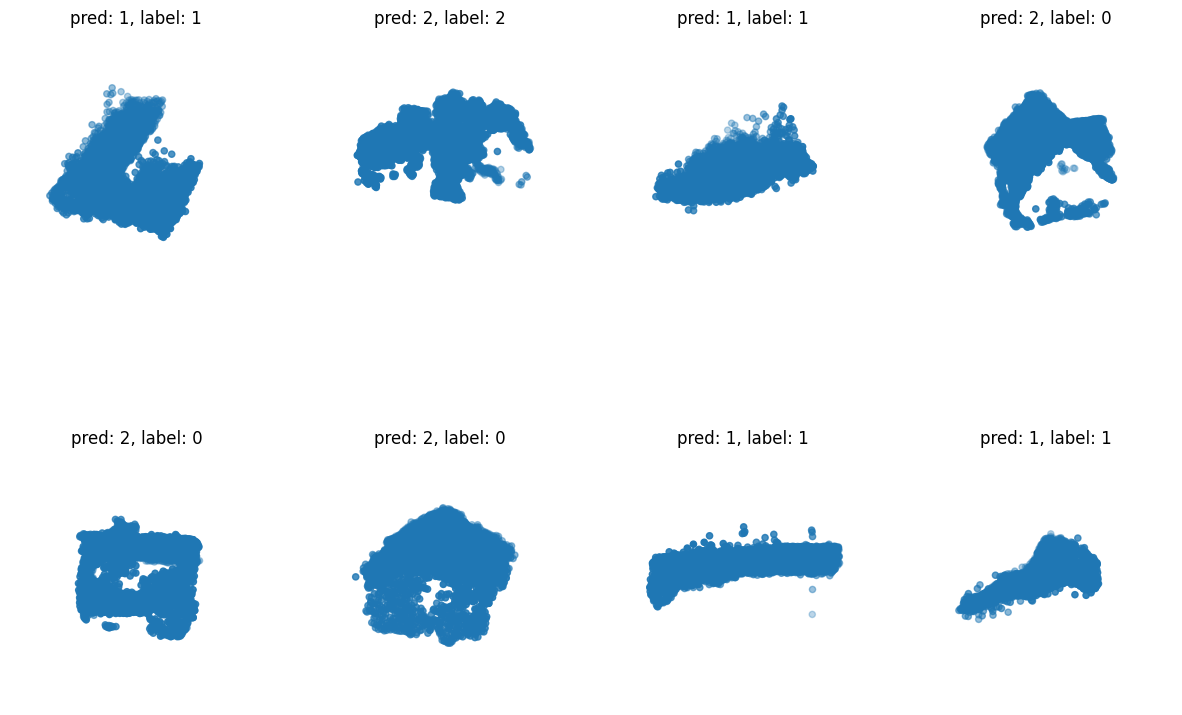

In [25]:
data = test_dataset.take(1)

points, labels = list(data)[0]
points = points[:8, ...]
labels = labels[:8, ...]

# run test data through model
preds = saved_model.predict(points)
preds = tf.math.argmax(preds, -1)

points = points.numpy()

# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "pred: {:}, label: {:}".format(preds[i].numpy(),labels.numpy()[i])
    )
    ax.set_axis_off()
plt.show()


In [26]:
dataset = test_dataset
total_count = 0
correct_count = 0
expected = []
predicted = []
accuracy_arr = []

for element in dataset.as_numpy_iterator():
    points = element[0]
    labels = element[1]
    pred = saved_model.predict(points)
    pred = tf.math.argmax(pred, -1)
    for index, point in enumerate(points):
        pred = saved_model.predict(points)
        pred = tf.math.argmax(pred, -1)
        total_count += 1
        predicted.append(pred[index])
        expected.append(labels[index])
        if labels[index] == pred[index]:
            correct_count += 1
        
        accuracy  = correct_count / total_count
        print("Accuracy  is {}".format(accuracy))
        accuracy_arr.append(accuracy)
            
accuracy  = correct_count / total_count
print("Accuracy  is {}".format(accuracy))

1/1 [==============================] - 1s 696ms/step
Accuracy  is 1.0
1/1 [==============================] - 1s 706ms/step
Accuracy  is 1.0
1/1 [==============================] - 1s 538ms/step
Accuracy  is 1.0
1/1 [==============================] - 1s 568ms/step
Accuracy  is 0.75
1/1 [==============================] - 1s 659ms/step
Accuracy  is 0.6
1/1 [==============================] - 1s 800ms/step
Accuracy  is 0.5
1/1 [==============================] - 1s 791ms/step
Accuracy  is 0.5714285714285714
1/1 [==============================] - 1s 723ms/step
Accuracy  is 0.625
1/1 [==============================] - 1s 664ms/step
Accuracy  is 0.5555555555555556
1/1 [==============================] - 1s 701ms/step
Accuracy  is 0.5
1/1 [==============================] - 1s 692ms/step
Accuracy  is 0.45454545454545453
1/1 [==============================] - 1s 640ms/step
Accuracy  is 0.5
1/1 [==============================] - 1s 522ms/step
Accuracy  is 0.46153846153846156
1/1 [====================

In [29]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

In [27]:
label_names = np.array(['building','ground','vegetation'])

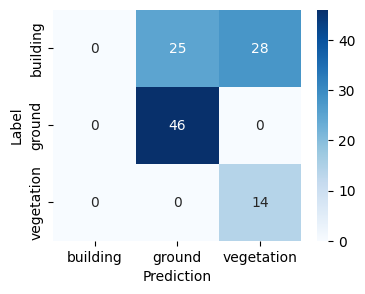

Accuracy: 0.530973
Precision: 0.530973
Recall: 0.530973
F1 score: 0.530973
              precision    recall  f1-score   support

    building       0.00      0.00      0.00        53
      ground       0.65      1.00      0.79        46
  vegetation       0.33      1.00      0.50        14

    accuracy                           0.53       113
   macro avg       0.33      0.67      0.43       113
weighted avg       0.31      0.53      0.38       113



/usr/local/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
confusion_mtx = tf.math.confusion_matrix(expected, predicted)
plt.figure(figsize=(4, 3))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g',cmap="Blues")
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

accuracy = accuracy_score(expected, predicted)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)  58/(58+6)  : was something else but predicted b,g,v
precision = precision_score(expected, predicted, average='micro')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)   58/(58+6)  : was b,g,v but predicted as something else
recall = recall_score(expected, predicted, average='micro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)  2*58/(2*58+6+6)
f1 = f1_score(expected, predicted, average='micro')
print('F1 score: %f' % f1)

print(classification_report(expected, predicted,target_names=label_names))
